<a href="https://colab.research.google.com/github/sseunghyuns/AI_project/blob/main/dogs_vs_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='darkblue'>대회 소개</font>

### Dogs vs. Cats Redux: Kernels Edition
**Distinguish images of dogs from cats**  
https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

---

***Description***

In 2013, we hosted one of our favorite for-fun competitions:  Dogs vs. Cats. Much has since changed in the machine learning landscape, particularly in deep learning and image analysis. Back then, a tensor flow was the diffusion of the creamer in a bored mathematician's cup of coffee. Now, even the cucumber farmers are neural netting their way to a bounty.

Much has changed at Kaggle as well. Our online coding environment Kernels didn't exist in 2013, and so it was that we approached sharing by scratching primitive glpyhs on cave walls with sticks and sharp objects. No more. Now, Kernels have taken over as the way to share code on Kaggle. IPython is out and Jupyter Notebook is in. We even have TensorFlow. What more could a data scientist ask for? But seriously, what more? Pull requests welcome.

We are excited to bring back the infamous Dogs vs. Cats classification problem as a playground competition with kernels enabled. Although modern techniques may make light of this once-difficult problem, it is through practice of new techniques on old datasets that we will make light of machine learning's future challenges.



---

## <font color='darkblue'>데이터 준비 및 확인</font>

#### 이미지 분류 대회에서 ...
* 아이디어 얻기 위해 데이터 하나 하나 뜯어보며 이미지 형태를 파악해야 한다.

* 머신러닝 대회에서 독립변수의 개수가 같아야 하는 것처럼 딥러닝에서도 Input 크기가 같아야 한다. 따라서 크기 조정 등의 최소한의 전처리가 필요하다.
* 이미지 크기 조정 시 이미 작은 이미지는 상관 없는데, 큰 이미지를 작은 이미지로 축소할 때 정보의 손실이 있을 수 있다.(나중에 더 깊게 다룰 예정)

#### 이미지 분류 베이스 라인 잡기
* `Data Preprocessing`
    - glob 이용하여 데이터 불러오기
    - 이미지 경로, 이미지 클래스를 칼럼으로 갖는 데이터 프레임 만들기
    - train_test_split으로 train, valid 데이터 만들기
        - stratify 옵션으로 label 비율 맞춰서 데이터셋 나누기
    - keras의 ImageDataGenerator 라이브러리를 사용하여 이미지 데이터 전처리하기
        
* `Modeling`
    - 모델 선언 및 학습 층 쌓기
    - 최적화 함수, 손실 함수 정하기
* `train`
    - 모델로 전처리된 이미지 학습하기

## <font color='darkblue'> 데이터 확인 </font>

In [ ]:
import numpy as np 
import pandas as pd 
import os

!unzip '/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip'
!unzip '/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip'

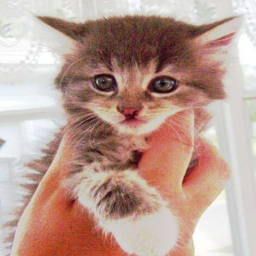

In [ ]:
from PIL import Image
Image.open('train/cat.100.jpg').resize((256,256))

## <font color='darkblue'>이미지 경로, 클래스를 칼럼으로 갖는 데이터프레임 만들기

In [ ]:
import glob
train = pd.DataFrame({"path" : glob.glob("train/*")})
train['label'] = train['path'].apply(lambda x : x.split("/")[-1].split(".")[0])
train

,path,label
0,train/dog.10300.jpg,dog
1,train/cat.7540.jpg,cat
2,train/dog.5684.jpg,dog
3,train/cat.10367.jpg,cat
4,train/cat.537.jpg,cat
...,...,...
24995,train/cat.2300.jpg,cat
24996,train/dog.7893.jpg,dog
24997,train/dog.8167.jpg,dog
24998,train/dog.6154.jpg,dog


## <font color='darkblue'>Train, Valid 셋 만들기

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(train,
                                 test_size = 0.2,
                                  stratify = train['label'],
                                 random_state = 42)

## <font color='darkblue'>keras의 ImageDataGenerator 사용하여 데이터 전처리

#### `Data Augmentation`

* 대회별로 도움되는 변형 옵션을 찾아야 한다.
* 데이터 변형을 한다고 해서 이미지 수가 두배가 되는게 아니다.

* 에폭당 50%확률로 변형이 적용되는데, 이는 ImageDataGenerator()에서 50%확률로 default 값이 지정되어 있기 때문이다. 
    * 한 `epoch`당 원본 이미지 50% + 변형 이미지 50%가 학습되는 것이므로, `Data Augmentation`을 할 때는 최소 여러 번의 `epoch`를 돌게 만들자.
    * 어떤 변형 옵션이 도움이 되는지 확인할 때는 이미지 사이즈를 줄이고 배치 사이즈를 늘려 빨리 실험해보자.
    * 평가할 때는 원본 이미지에 대해서 `predict`가 이루어져야 하기 때문에 `idg_val = ImageDataGenerator()`를 따로 지정해주는 것이다.
    * ImageDataGenerator()를 커스터마이징하여 값을 바꿀 수도 있다.
---

#### `flow_from_dataframe` 옵션
* `target_size`
    * 이미지 사이즈를 키우게 되면 정보 손실이 덜 하므로 그만큼 점수가 좋아진다.
    * 원본 이미지의 사이즈가 클 경우 target_size를 이에 비슷하게 맞추는 것이 이상적이지만, 그만큼 학습 속도가 느려지게 된다. 또한 메모리 문제로 인해 target_size를 늘리면 batch_size를 줄여야 한다. 
    * 원본 이미지가 작은 경우 사이즈를 키웠다고 해서 더 성능이 좋아지는 것은 아니다.
* `batch_size` 
    * batch_size 역시 모델 성능(점수)에 영향을 준다.


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

idg_train = ImageDataGenerator(horizontal_flip=True)
idg_valid = ImageDataGenerator()
idg_test = ImageDataGenerator()

train_generator = idg_train.flow_from_dataframe(X_train, # df 이름
                                          x_col = 'path', # 이미지 path
                                          y_col = 'label',# 클래스
                                          batch_size = 32, # 기본값 32 -> 처음엔 100으로 설정하여 학습 속도를 빠르게 하기도 함.
                                          target_size = (256,256)) # 기본값 256

                                          
valid_generator = idg_valid.flow_from_dataframe(X_val,
                                               x_col = 'path',
                                               y_col = 'label',
                                                batch_size = 32,
                                                target_size = (256,256))

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


## <font color='darkblue'>모델링

`모델 선언` : **Sequential()**로 모델을 먼저 선언한다.

- `이미지 학습하는 층 쌓기`: **기본적인 모델 구조를 설정한다. Conv2D함수 안에 n개의 feature map을 추출한다.**
    - 첫 layer에서는 **input_shape**을 설정해 주자. (256,256,3)
    - activation 함수를 적용하여 하나의 층이 비선형적인 학습을 할 수 있도록 한다. 
    - 하나의 **Conv2D** 층을 하나의 분류기라고 생각하자. 머신러닝에서 하나의 랜덤 포레스트 모델로 생각하면 쉽다.여러 개의 랜덤포레스트를 앙상블하면 학습에 도움이 되는 것처럼 여러 **Conv2D**층을 쌓으면 여러 특징들을 추출해낼 수 있기 때문에 학습에 도움이 된다.
    - **Conv2D** 층만 쌓게 되면 중요하지 않은 배경들도 똑같이 고려하게 되므로 학습이 어려워진다.합성곱층 통과 후 가장 특징적인 값만 가져오는   **MaxPool2D**층을 추가해주자.
    
    
- `차원 축소하기` 
    - **Conv2D** 채널을 지나서 나오는 피처맵들은 3차원 이미지 데이터들이다. **Flatten()**으로 3차원 데이터를 1차원으로 펼쳐준다.
    - **Flatten()** : 이미지 내 지역에 대한 고려 없이 1차원으로 펼처준다. 지역적인 정보가 날아갈 수 있다. 
    - **GlobalAveragePooling2D()** : 지역을 고려하여 2D형태로 펼쳐준다. Flatten대신 많이 사용한다.
    
    
- `Output layer 설정하기` : **마지막 층은 학습하는 것이 아니라 각 클래스에 대한 확률값으로 값이 출력되어야 한다.**
    - 다중 분류시 **softmax**를 사용한다.
    
    
- `최적화함수, 손실함수 정의하기`
    - 모델의 정확도를 확인할 수 있도록 metrics를 설정한다.
    - 최적화함수는 **Adam**, 손실함수는 **categorical_crossentropy**로 설정한다.
    - **adam**'s default Learning Rate =  0.001


- `모델 학습시키기`
    - **epochs** : 한번의 `epochs`을 반복할 때마다 전체 데이터를 *한번* 학습하게 된다. 학습을 여러번 시킬수록 점수 향상에 도움이 되지만 과대적합 문제가 발생할 수 있다.

`모델 summary` : **모델 구조를 출력한다.**

In [ ]:
from keras import * 
from keras.layers import * 

# 모델 선언 
model = Sequential()

# 이미지 학습하는 층을 쌓기
model.add(Conv2D(16, (3,3), activation = 'relu', input_shape = (256,256,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, (3,3), activation = 'relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, (3,3), activation = 'relu'))
model.add(MaxPool2D())

model.add(Conv2D(256, (3,3), activation = 'relu'))
model.add(MaxPool2D())

model.add(Conv2D(512, (3,3), activation = 'relu'))
model.add(MaxPool2D())

# 차원 축소
#model.add(Flatten())
model.add(GlobalAveragePooling2D())

# model.add(Dropout(0.5))
# model.add(Dense(512, activation = 'relu'))
# model.add(Dense(256, activation = 'relu'))

model.add(Dense(2, activation = 'softmax'))

# 최적화, 손실 함수 정의하기
model.compile(metrics = ['acc'], optimizer= 'adam', loss='categorical_crossentropy')

model.fit(train_generator,
         validation_data=valid_generator,
        epochs= 10
         )

Epoch 1/10
625/625 [==============================] - 93s 149ms/step - loss: 1.3097 - acc: 0.5896 - val_loss: 0.6291 - val_acc: 0.6382
Epoch 2/10
625/625 [==============================] - 93s 149ms/step - loss: 0.5652 - acc: 0.7053 - val_loss: 0.5327 - val_acc: 0.7402
Epoch 3/10
625/625 [==============================] - 95s 153ms/step - loss: 0.4760 - acc: 0.7775 - val_loss: 0.4140 - val_acc: 0.8166
Epoch 4/10
625/625 [==============================] - 93s 149ms/step - loss: 0.4070 - acc: 0.8147 - val_loss: 0.3493 - val_acc: 0.8484
Epoch 5/10
625/625 [==============================] - 93s 148ms/step - loss: 0.3471 - acc: 0.8486 - val_loss: 0.4356 - val_acc: 0.8134
Epoch 6/10
625/625 [==============================] - 93s 149ms/step - loss: 0.3118 - acc: 0.8680 - val_loss: 0.3170 - val_acc: 0.8708
Epoch 7/10
625/625 [==============================] - 93s 148ms/step - loss: 0.2792 - acc: 0.8821 - val_loss: 0.2858 - val_acc: 0.8822
Epoch 8/10
625/625 [==============================] - 9

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 128)      

## <font color='darkblue'>전이학습(**Transfer Learning**)

### ***Imagenet*** 등의 빅데이터로 학습된 모델을 가져와 쓰기

Pretrained Model : `EfficientNet`
- 작년에 나온 모델로, 이미지 분류 대회에서 압도적으로 쓰인다. B0 ~ B7까지 버전이 있고, B2 이상으로 갈수록 모델이 많이 무거워진다.


- `pretrained model` 사용시 알아야할 3가지 필수 옵션
    1. `include_top` : 마지막 출력층(top)을 포함할 것인지 여부 결정. **False**로 설정한 후 문제 상황에 맞게 분류기를 바꿀 수 있다.
    2. `weights` : **imagenet**으로 설정 시, Imagenet을 통해 학습된 가중치를 사용하게 된다.    
        - 학습된 가중치를 사용했을 때 장점
            1. 대부분의 분류 문제에서 별다른 하이퍼파라미터 튜닝 없이 정확도가 8~90%가 나온다.
            2. 사진들끼리 공유하고 있는 특징(배경, 직선, 명암, 색체 등)이 있기 때문에 `imagenet`의 클래스에 없는 이미지에 대해서도 곧잘 분류한다.
    3. `pooling` : **avg** 설정 시 분류층 직전에 Global average pooling을 적용한다.
        - 이미지 분류 문제에서는 대부분 classifier 전에 gap를 사용한다. 앞서 `모델링`파트에서 소개했듯이 지역적 정보를 가져오기 때문이다.
        - 이미지 분류가 아닌 detection, segmentation, 음성 데이터 처리, 혹은 text mining 등의 경우 Flatten을 사용 시 모델의 성능이 잘 나오기도 한다. 딥러닝에서 정답은 없다. 많이 시도해봐야 한다.
    
    
* `freeze`
    * `freeze`시킴으로써 층을 선택적으로 학습을 시킬 수 있다. 
    * 데이터가 적으면 pretrained model의 feature extract 층은 얼리고 classifer 층만 학습시키기도 한다. 

---


## <font color='darkblue'>Callbacks 옵션

### 여러가지 기법들로 모델 성능 높이기

- `EarlyStopping`
    * 조기 종료 옵션이다.
        - `patience` : default로 val_loss를 monitor한다. 하이퍼파라미터로 설정한 양의 정수만큼 val_loss가 떨어지는 것을 참고 지켜보게 된다. 
            - 만약 val_loss가 0.4 -> 0.45 -> 0.42로 높아졌을 때, 두 경우 모두에서 patience가 누적된다. 두 값 모두 0.4보다 높기 때문이다. 즉, 최적의 순간보다 val_loss가 n번 ***연속*** 좋아지지 않으면 멈춘다.


- `ModelCheckpoint`
    * 모델 최적의 가중치를 저장하는 옵션이다.
    * EarlyStopping을 사용했을 경우, 10번째가 최적일 시 13번째까지 학습하고 마지막 13번째의 가중치가 남아있게 된다. 체크포인트를 통해 10번째의 가중치를 가져올 수 있게 된다.
    * `model.load_weights()` 옵션으로 저장된 모델을 불러오는 것을 잊지 말자.
    
    
- `ReduceLROnPlateau`
    * Learning rate가 컸을 때, 최적점 주변을 멤돌거나 지나쳐서 성능이 오히려 안좋아질 수 있다. 
    * Learning rate(학습 보폭)를 조정하여 최적점에 도달하는데 도움을 줄 수 있다.
    * 학습이 멈추기 전 작동해야하므로 항상 EarlyStopping의 `patience` 값 보단 작게 해야 한다. 
    * `factor` 하이퍼파라미터의 기본값 : 0.1
    * `min_lr` 하이퍼파라미터의 기본값 : 0

In [ ]:
from tensorflow.keras import * 
from tensorflow.keras.layers import * 
from tensorflow.keras.applications.efficientnet import EfficientNetB1 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# transfer learning
model = Sequential() # 항상 모델 선언 다시 하고 학습할 것

model.add(EfficientNetB1(include_top=False, weights = 'imagenet', pooling = 'avg')) 

# classifier
model.add(Dense(2, activation='softmax')) 


# 최적화 함수, 손실 함수 정의하기
model.compile(metrics = ['acc'], optimizer= 'adam', loss='categorical_crossentropy')


# callbacks 설정하기
es = EarlyStopping(patience=3,  
                   verbose=True)

mc = ModelCheckpoint("best.h5", #h5:가중치 저장 확장자
                    save_best_only = True, 
                    verbose=True)

rlp = ReduceLROnPlateau(patience = 2,
                       verbose=True)

# 모델 학습하기
model.fit(train_generator,
         validation_data  = valid_generator,
         epochs = 100,
         callbacks = [es, mc, rlp],) 

model.load_weights('best.h5')

27025408/27018416 [==============================] - 0s 0us/step
Epoch 1/100
625/625 [==============================] - ETA: 0s - loss: 0.0914 - acc: 0.9660
Epoch 00001: val_loss improved from inf to 0.06357, saving model to best.h5
625/625 [==============================] - 276s 442ms/step - loss: 0.0914 - acc: 0.9660 - val_loss: 0.0636 - val_acc: 0.9768
Epoch 2/100
625/625 [==============================] - ETA: 0s - loss: 0.0578 - acc: 0.9794
Epoch 00002: val_loss did not improve from 0.06357
625/625 [==============================] - 272s 435ms/step - loss: 0.0578 - acc: 0.9794 - val_loss: 0.1416 - val_acc: 0.9416
Epoch 3/100
625/625 [==============================] - ETA: 0s - loss: 0.0433 - acc: 0.9841
Epoch 00003: val_loss did not improve from 0.06357

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
625/625 [==============================] - 273s 437ms/step - loss: 0.0433 - acc: 0.9841 - val_loss: 0.0679 - val_acc: 0.9750
Epoch 4/100
598/625 [===

KeyboardInterrupt: 

# <font color='darkblue'>제출하기
* Test셋 예측 후 제출하기
    * Train셋과 마찬가지로 test_generator 만들어준다.
    * Test셋에는 레이블이 없으므로, `y_col = None`, `class_mode = None` 옵션 넣어줘야 한다.
    * 학습 시에는 데이터가 섞여도 되지만, predict할 때는 index가 섞일 수 있으니 `shuffle = False` 옵션을 넣어준다.

In [ ]:
test = pd.DataFrame({"path" : glob.glob("test/*")})


test_generator = idg_test.flow_from_dataframe(test,
                                               x_col = 'path',
                                               y_col = None,
                                              class_mode=None,
                                              shuffle = False,
                                              target_size = (256,256))

In [ ]:
result = model.predict(test_generator, verbose = 1)
result 

* `verbose = 1` : 모델 예측 진행 상황을 볼 수 있다.
* result의 값을 출력해보면 클래스가 2개이므로 확률값 2개가 나온다.

In [ ]:
train_generator.class_indices 

* `train_generator.class_indices` 로 각 클래스의 변환값을 알 수 있다. 
* 보통 0(False), 1(True)값이므로 이진 분류 대회에서는 1의 확률값을 제출한다.

In [ ]:
sub = pd.read_csv("/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv")
sub['label'] = result[:,1] 
sub['id'] = test['path']
sub['id'] = sub['id'].apply(lambda x : x.split("/")[1].split(".")[0])
sub

* `lable`이 `id`와 매핑되도록 바꿔줘야한다.현재 모델은 `test['path']`의 순서대로 예측값을 계산했는데, `sub['id']`는 index가 0부터이다.

In [ ]:
sub.to_csv("sub.csv",index=False) 